In [26]:
basedir="/home/caskeylab/Vandiver/repos/hifu/"

import sys
sys.path.append(basedir+'/code/BioHeat/BioHeatCpp/PBHEswig/custom/')
sys.path.append(basedir+'/code/myPy/')

import PBHEswig
import numpy as np
import geom
import transducers
import ablation_utils

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as image

%matplotlib inline

In [3]:
#Thermal parameters
rho=1000 #Medium density kg / m^3
Cp=3700 #Heat capacity. J / (kg * degrees K)

c0=1540 #sound speed m/s
f0=1.2e6 #Sonication frequency in Hz
k0=f0*2*np.pi/c0 
ktdiffusion=0.6  #Thermal conductivity

In [42]:
#Create 3/4D grid

xw=3.0 #width of grid (cm)
yw=3.0 #width of grid (cm)
zmin=4.0 #min z coordinate of grid (cm)
zmax=8.0 #min z coordinate of grid (cm)

#thermal simulation time step:
dt = 0.1

alpha_acc = 5.0 #Attenuation in nepers / m

Nt=25
Nx=80
Ny=80
Nz=64

dataType = np.float32  # should be np.float, np.float32 or np.float64.  np.float is just a reference to the default type

simPhysGrid = ablation_utils.makeSimPhysGrid(nt=Nt,nx=Nx,ny=Ny,nz=Nz,rho=rho, ktherm=ktdiffusion, f0=f0,Cp=Cp,c0=c0,
    dt=dt, xr=[-xw/2.0, xw/2.0], yr=[-yw/2.0, yw/2.0],zr=[zmin,zmax])

list(simPhysGrid.keys())

['kmesh',
 'Tdot',
 'Tmesh',
 'k0',
 'rho',
 'kt',
 'c0',
 'yrp',
 'xrp',
 'dtxyz',
 'rhoCpmesh',
 'rhoCp',
 'T',
 'Tdotmesh',
 'zrp']

In [22]:
#resolution. seconds, m, m ,m
simPhysGrid['dtxyz']

array([ 0.1       ,  0.00037975,  0.00037975,  0.00063492], dtype=float32)

In [16]:
#Setup a transducer model
ROC = 0.064 #radius of curvature in meters
diameter = 0.0632 #diameter at the opening face in meters
(uxyz, nn) = geom.new_stipled_spherecap_array(ROC, diameter, 100)

unormals = [0., 0., ROC] - uxyz
unormals /= np.sqrt(np.sum( unormals**2))

In [8]:
uxyz.shape

(98, 3)

In [14]:
uxyz[:,2].max()

0.0083453505985349001

In [43]:
#Gives complex pressure field
Pr = transducers.calc_pressure_field(k0, uxyz, np.ones(nn), simPhysGrid['xrp'], simPhysGrid['yrp'], simPhysGrid['zrp'], unormals=unormals )

normalization = 3e6 / np.abs(Pr).max()

In [29]:
normalization

11771.120319943651

In [30]:
P2 = transducers.calc_pressure_field(k0, uxyz, normalization*np.ones(nn), simPhysGrid['xrp'], simPhysGrid['yrp'], simPhysGrid['zrp'], unormals=unormals )


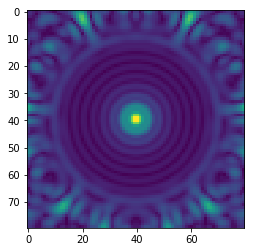

In [27]:
plt.imshow(np.abs(Pr[:,:,45]))

In [55]:
tstarts = [0.0, 15.0]
tstops = [15.0, 25.0]

uamplitudes = np.zeros([len(tstarts), nn])
uamplitudes[0] = normalization*np.ones(nn)
uamplitudes[1] = 0 

#set initial temperature. Can be a scalar value or 3D array
simPhysGrid['T'][0] = 22.0

times = np.arange(0.0, tstops[-1], 0.1)
avgTemp = np.zeros_like(times)

def heatInterpFunc(temp3d):
    
    #idx=heatInterpFunc.idx
    #heatInterpFunc.Tavg[idx] = np.mean(temp3d[35:45,35:45,35:45])

    return np.mean(temp3d[35:45,35:45,35:45])


CEM = ablation_utils.sonicate4D(simPhysGrid, tstarts, tstops, uamplitudes, [uxyz], [unormals], 
                                calcField=True, verbose=True,
                               PBkeys=dict(interpTimes=times, interpolatedTemp=avgTemp, interpFunc=heatInterpFunc) )




  2/  2, 100% 

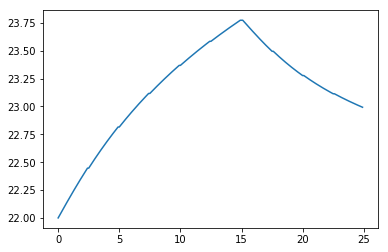

In [56]:
plt.plot(times, avgTemp)

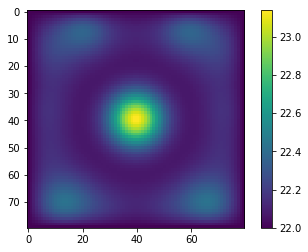

In [49]:
plt.imshow(simPhysGrid['T'][-1,:,:,45])
plt.colorbar()

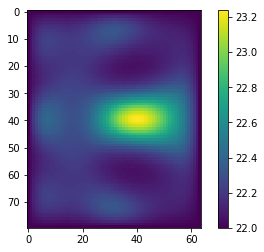

In [50]:
plt.imshow(simPhysGrid['T'][-1,39,:,:])
plt.colorbar()